In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import xgboost as xgb
import eli5
sns.set_style("darkgrid")

In [35]:
df = pd.read_csv("data/train.csv")

Text(0.5, 1.0, 'Runtime')

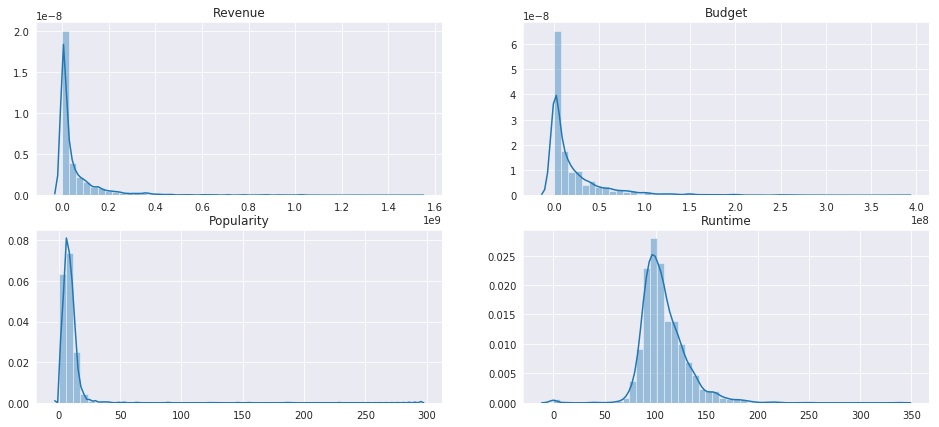

In [36]:
# Distribution of float variables
fig, axes = plt.subplots(2,2, figsize=[16, 7])
sns.distplot(df["revenue"], ax=axes[0][0], axlabel=False)
axes[0][0].set_title("Revenue")
sns.distplot(df["budget"], ax=axes[0][1], axlabel=False)
axes[0][1].set_title("Budget")
sns.distplot(df["popularity"], ax=axes[1][0], axlabel=False)
axes[1][0].set_title("Popularity")
sns.distplot(df["runtime"].dropna(), ax=axes[1][1], axlabel=False)
axes[1][1].set_title("Runtime")

In [37]:
df["log_revenue"] = np.log1p(df["revenue"])
df["log_budget"] = np.log1p(df["budget"])

In [38]:
for index , row in df.iterrows():
    try:
        for i in eval(row["genres"]):
            name = i["name"]
            try:
                df.loc[index, name] = 1
            except KeyError:
                df[name] = 0
                df.loc[index, name] = 1
    except TypeError:
        pass
            

In [39]:
for var in ['Comedy', 'Drama', 'Family', 'Romance','Thriller', 'Animation', 'Adventure', 'Horror', 'Music', 'Crime','Action', 'Science Fiction', 'Mystery', 'Fantasy', 'War', 'Western','Foreign', 'History', 'Documentary', 'TV Movie']:
    df[var] = df[var].fillna(0)

In [40]:
cols = []
for index, row in df.iterrows():
    try:
        for i in eval(row["production_companies"]):
            company = i["name"]
            cols.append(company)
            try:
                df.loc[index, company] = 1
            except KeyError:
                df[company] = 0
                df.loc[index, company] = 1
    except TypeError:
        pass

for col in set(cols):
    df[col] = df[col].fillna(0)

## Feature Selection

In [69]:
# Remove all features that are either one or zero (on or off) in more than 80% of the samples
low_variance_vars = []
for col in df.columns:
    try:
        if (sum(df[col].unique()) == 1) & (len(df[col].unique()) == 2):
            if any(i >= df.shape[0]*0.8 for i in df[col].value_counts()):
                low_variance_vars.append(col)
    except TypeError:
        pass
        
        
        

In [72]:
df = df.drop(low_variance_vars, axis=1)

In [73]:
drop_cols = ['id', 'revenue', "log_revenue", "log_budget","belongs_to_collection", "genres", "homepage", "imdb_id", 
             "original_language", "original_title", "overview", "poster_path", "production_companies", 
             "production_countries", "release_date", "spoken_languages", "status", "tagline", "title", 
             "Keywords", "cast", "crew"]
X = df.drop(drop_cols, axis=1)
y =df['log_revenue']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [74]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}

lgb_model = lgb.LGBMRegressor(**params, n_estimators = 10000, nthread = 4, n_jobs = -1)
lgb_model.fit(
    X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',verbose=1000, 
    early_stopping_rounds=500
)
eli5.show_weights(lgb_model, feature_filter=lambda x: x != '<BIAS>')

Training until validation scores don't improve for 500 rounds.
[1000]	training's rmse: 1.79567	valid_1's rmse: 2.50243
Early stopping, best iteration is:
[1176]	training's rmse: 1.76482	valid_1's rmse: 2.50122


Weight,Feature
0.5384,budget
0.2882,popularity
0.1201,runtime
0.0238,Drama
0.0155,Comedy
0.0071,Thriller
0.0069,Action
